Main imports

In [1]:
# generic functions
# some generic constants and arrays are defined at the beginning of this file
from modules.my_functions import *

# functions for the dark matter halo catalogue
from modules.dark_matter_haloes import *

# functions for assigning and evolving galaxies
from modules.galaxies import *

# functions for building black holes
from modules.black_holes import *

# function for the Mancuso+2016 luminosity function
from Mancuso_Lapi_SFRF.SFRF import *

Set input parameters here

In [2]:
# if True: use reduced catalogue of ~10000 dark matter haloes
# if False: use bigger catalogue of ~100000 dark matter haloes
reduced_catalogue=True

# scatter in SFR at fixed halo accretion rate (HAR)
sigma_sfr = 0.3
delay=False
# choose luminosity function
# implemented: "Sargent+2012", "Mancuso+2016", "Fujimoto+2023"
luminosity_function="Mancuso+2016"

# if True: quench galaxies with halo mass above threshold (Dekkel+2007)
halo_quenching=True
# quenching halo mass threshold
logMhDekkel = 12.
# scatter around mass threshold
scatter_mhlog_crit = 0.1

# if True: quench galaxies above mean Mbh-sigma relation
blackhole_quenching=False
# scatter in black hole accretion rate (BHAR) at fixed stellar mass
sigma_mbhdot = 0.3
# choose BHAR-Mstar relation
# implemented: "Yang+2018", "Carraro+2020"
bhar_function="Yang+2018"
# choose how to assign velocity dispersion
# implemented: "Ferrarese+2002", "Marsden+2022"
velocity_dispersion="Ferrarese+2002"

morphological_quenching=False

# if True: quench galaxies when major merger occurs
#if True, merger_tree must be set to "SatGen"
mergers_quenching=False

# if True: add stellar mass from mergers
# if False: galaxies grow only via star formation
include_mergers=True
# just set to SatGen
#merger_tree="DECODE"
merger_tree="SatGen"
# major merger mass ratio threshold
mratio_threshold=0.25

# fraction of mass that goes to the disc during disc regrowth
f_discregrowth=0.5
# if True: add disc instabilities (Bournaud+2011)
add_disc_inst=True

In [3]:
# read dark matter halo catalogue (parent haloes or central subhaloes)
# nhalo: number of haloes
# mhlog_arr: log Mhalo, 2D-array (index_redshift x index_halo)
# dmhdtlog_arr: log HAR, 2D-array (index_redshift x index_halo)
nhalo, mhlog_arr, dmhdtlog_arr = dark_matter_halo_catalogue(reduced_catalogue,nz)

In [4]:
# halo mass function
hmf, hmflog, hmf_cum, norm, volume, cube_side, hmf_cat = halo_mass_function(z,nz,nhalo,mhlog_arr,mhlog,nmh,mhlog_min)

Volume cube side: 83.896718 Mpc


The following 4 cells computes the HAR function, divided by those hosting active/passive or all galaxies

At $z>0$ there are objects missing, because the catalogue contains only surviving haloes at $z=0$

To account for the missing haloes, we use the correction factor from Boco+2023

In [5]:
# calcolo la HMF dal catalogo di aloni. Ad alto z essi evolvono usando Hearin e quindi la HMF non sarà la stessa di quella analitica
mhlog_cat,dNdmhlog_cat,norm_histo=hmf_catalogue(z,nz,mhlog_arr,hmflog,mhlog,mhlog_min_cat)

In [6]:
#Correggo la hsar pesando diversamente gli aloni con varie masse, a seconda di quanti ne mancano nel mio catalogo
#rispetto alla HMF.
hsarlog_cat=dmhdtlog_arr+9.-mhlog_arr
dNdhsarlog,jsoglia,bins,dpdhsarlog=hsar_function(z,nz,hsarlog,nhsar,hsarlog_cat,mhlog_arr,mhlog,nhalo,mhlog_min,hmf,mhlog_cat,dNdmhlog_cat,norm,norm_histo)

In [7]:
nmhdot=1000
mhdotlog=np.linspace(0.5,17.,nmhdot)
dpdlogmhdot = har_distribution(mhdotlog, nmhdot, hsarlog, nhsar, dpdhsarlog, z,nz,mhlog,nmh)

In [8]:
mhlog_crit = halo_mass_crit_quench_givenparams(1.4, 0.5, logMhDekkel, halo_quenching)
dpdlogmhdot_active, dpdlogmhdot_passive = har_distrib_ac_pas(dpdlogmhdot,z,nz,mhlog,nmh,mhlog_crit)
dNdVdlogmhdot_active, dNdVdlogmhdot_passive, dNdVdlogmhdot = har_function(z,nz,mhlog,nmh,nmhdot, hmf, dpdlogmhdot_active, dpdlogmhdot_passive, dpdlogmhdot)

In [10]:
#Fujimoto+2023
logLs=np.arange(7.,14.01,0.1)
nLs=logLs.size
LF,logLF=IRLF(z,nz,logLs,nLs)

In [11]:
# compute SFR functions
phisfrLF_Sargent = sfr_function(z,nz,sfrlog,nsfr)
phisfr_lapi, phisfr_etg_lapi, phisfr_ltg_lapi = SFR_function_UV_IR_Mancuso_Lapi([nz,z,nsfr,sfrlog])# Mancuso, Lapi + 2016
phisfrLF_Fujimoto = compute_SFR_function_from_LF(nz, z, nLs, logLs, LF, nsfr, sfrlog, 50**3, 7.)

In [12]:
# choose SFR function
if luminosity_function=="Sargent+2012":
    phisfrLF=phisfrLF_Sargent.copy()
elif luminosity_function=="Mancuso+2016":
    phisfrLF=phisfr_lapi.copy()
elif luminosity_function=="Fujimoto+2023":
    phisfrLF=phisfrLF_Fujimoto.copy()

In [33]:
# abundance matching between phi(sfr) and phi(Mhdot)
# sfr_am, sfrlog_am: SFR and logSFR [Msun/yr]
sfr_am, sfrlog_am = abundance_matching(z,nz,mhdotlog,nmhdot, phisfrLF,sfrlog,nsfr, dNdVdlogmhdot_active, sigma_sfr, delay)
if luminosity_function=="Fujimoto+2023":
    # this is a modification made by hand to smooth the bumps in the output SFR-HAR relation
    sfrlog_am=smooth_sfr_har_relation(nz,sfrlog_am,nmhdot,mhdotlog)

In [14]:
# import merger tree files
if include_mergers and merger_tree=="SatGen":
    tree=read_SatGen_merger_tree(reduced_catalogue,nz,z,nhalo,mhlog_arr)
elif include_mergers and merger_tree=="DECODE":
    from modules.compute_merger_rates_decode import *

Dynamical friction timescales computed.
Mass ratios computed.
Fudge factor computed.
Merging timescales computed
Redshift at merging computed.


In [79]:
# assign SFR using the SFR-HAR relation following the dark matter haloes accretion rate history
# sfrlog_cat: log SFR, 2D-array (index_redshift x index_galaxy)
# this function already quenches the star formation with halo mass
sfrlog_cat = sfr_catalogue(z,nz,nhalo,sfrlog_am,mhdotlog,dmhdtlog_arr,mhlog_arr,mhlog_crit,scatter_mhlog_crit,delay) + np.random.normal(0,sigma_sfr,(nhalo,nz))
# set SFR to zero for z>3, because the abundance matching is not accurate above that redshift
# this assumption implies that all surviving galaxies at z=0 are formed below z<3, and at z=3 all galaxies were star forming
sfrlog_cat[:,z>3]=-65. # impongo -65 perché voglio che la SFR sia 0, ma non deve essere contata come quenchata (le quenchate vengono classificate come logsfr==-66)

# integrate SFRs across cosmic time
mstar_integrated, logmstar_integrated = integrate_accretion_rates_across_time(z, sfrlog_cat+np.log10(1.-0.44))
# save a copy of the array for the without-mergers case
logmstar_integrated_NoMerg = logmstar_integrated.copy()

In [80]:
# add stellar mass accreted from mergers
if include_mergers and not blackhole_quenching:
    if merger_tree=="DECODE":
        mstar_integrated,logmstar_integrated,logMR_cat=add_mergers_Decode(z,nz,mslog,logmstar_integrated,nhalo,mhlog_arr,sfrlog_cat)
    elif merger_tree=="SatGen":
        mstar_integrated, logmstar_integrated, tree = add_mergers_SatGen_tree(nz,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree)

In [64]:
# velocity dispersion
logsigma_arr=assign_velocity_dispersion(nz,nhalo,mhlog_arr,logmstar_integrated,velocity_dispersion)

In [17]:
if blackhole_quenching and bhar_function=="Shen+2020":
    eps=0.1; logLx=np.arange(38,50.01,0.1); nLx = logLx.size
    Lxf = Xray_L_function(nz,z,nLx,logLx, work="shen+2020")
    phimbhdot_nocorr = compute_mbh_accrate_function(nz, z, nLx, logLx, Lxf, nmbhdot, mbhdotlog, eps, 150**3, 39., False, logmstar_integrated, sfrlog_cat, volume)
    phimbhdot = compute_mbh_accrate_function(nz, z, nLx, logLx, Lxf, nmbhdot, mbhdotlog, eps, 150**3, 39., True, logmstar_integrated, sfrlog_cat, volume)
    delta_mhlog_cat, delta_mhdotlog_cat, sats_mhlog_cat, sats_mhdotlog_cat = compute_sats_delta_mh_mhdot_forPhiTrue_abundancematching(nz,z,mhlog,hmf,hmf_cat,volume)

In [18]:
if blackhole_quenching:
    niter=2
else:
    niter=1
for it in tqdm(range(niter)):
    
    #UPDATE HAR FUNCTION AND ABUNDANCE MATCHING
    if it>0:
        new_dNdVdlogmhdot_active, sfr_am, sfrlog_am, sfrlog_cat, mstar_integrated, logmstar_integrated = update_SFR_HAR_abundance_matching(z,nz,hsarlog_cat,dmhdtlog_arr,mhlog_arr,mhlog,nhalo,mhlog_min,hmf,mhlog_cat,dNdmhlog_cat,norm,norm_histo,sfrlog_cat,phisfrLF,sigma_sfr)
    
    if bhar_function=="Shen+2020":
        phisfr_true,delta_sfrlog_cat,sats_sfrlog_cat = compute_phisfr_true(it,nz,z,volume,mhdotlog,sfrlog,sfrlog_am,mhlog_arr,sfrlog_cat,sats_mhlog_cat, delta_mhlog_cat, sats_mhdotlog_cat, delta_mhdotlog_cat)

    if it==0:
        if bhar_function=="Shen+2020":
            mbhdot_am, mbhdotlog_am = abundance_matching(z,nz,sfrlog,nsfr, phimbhdot, mbhdotlog, nmbhdot, np.transpose(phisfr_true), sigma_am=sigma_mbhdot)
            mbhdotlog_cat = sfr_catalogue(z,nz,nhalo,mbhdotlog_am, sfrlog+9., sfrlog_cat, logmstar_integrated, mhlog_crit) + np.random.normal(0,sigma_mbhdot,(nhalo,nz))
        else:
            mbhdotlog_cat=assign_BHAR_cat(z,nz,nhalo,sfrlog_cat,logmstar_integrated,bhar_function)
        mbhdotlog_cat[:,z>3]=-65.
        
        mbh_integrated, logmbh_integrated = integrate_accretion_rates_across_time(z, mbhdotlog_cat)

    phimbhdot_cat=compute_BHAR_function_cat(nmbhdot,nz,mbhdotlog_cat,mbhdotlog,volume)
    
    if blackhole_quenching:
        if it==0:
            logMbhcrit_arr=compute_critical_quenching_BH_mass(nsigma,logsigma,nz,z,nhalo,logsigma_arr,velocity_dispersion)
        elif it>0 and velocity_dispersion=="Marsden+2022":
            logsigma_arr=assign_velocity_dispersion(nz,nhalo,mhlog_arr,logmstar_integrated,velocity_dispersion)
            logMbhcrit_arr=compute_critical_quenching_BH_mass(nsigma,logsigma,nz,z,nhalo,logsigma_arr,velocity_dispersion)
        
        # QUENCHING
        masks = np.array([ quench_blackhole_mask(nz, z, logsigma_arr[im,:], logmbh_integrated[im,:], logsigma, logMbhcrit_arr[im,:]) for im in range(nhalo) ])
        sfrlog_cat,mbhdotlog_cat=quench_blackholes_galaxies(nz,nhalo,masks,sfrlog_cat,mbhdotlog_cat)
        
        mstar_integrated, logmstar_integrated = integrate_accretion_rates_across_time(z, sfrlog_cat+np.log10(1.-0.44))
        logmstar_integrated_NoMerg = logmstar_integrated.copy()
        
        mbh_integrated, logmbh_integrated = integrate_accretion_rates_across_time(z, mbhdotlog_cat)
        
        if include_mergers:
            if merger_tree=="DECODE":
                mstar_integrated,logmstar_integrated,logMR_cat=add_mergers_Decode(z,nz,mslog,logmstar_integrated,nhalo,mhlog_arr,sfrlog_cat)
            elif merger_tree=="SatGen":
                mstar_integrated, logmstar_integrated, tree = add_mergers_SatGen_tree(nz,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree)


100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [03:41<00:00, 110.73s/it]


In [19]:
if mergers_quenching:
    niter=2
    for Iter in range(niter):
        tree["mratio"]=np.array([ np.array([ 10.**(tree["mstar"][ihalo][i]-logmstar_integrated[ihalo,nearest(z,tree["z_merge"][ihalo][i])]) for i in range(tree["mhalo"][ihalo].size)]) for ihalo in range(nhalo) ])
        for ihalo in range(nhalo):
            if tree["mratio"][ihalo][np.logical_and.reduce((tree["z_merge"][ihalo]<3,tree["mratio"][ihalo]>=mratio_threshold,tree["order"][ihalo]<=1))].size>0:
                z_first_majormerger=np.nanmax(tree["z_merge"][ihalo][np.logical_and.reduce((tree["z_merge"][ihalo]<3,tree["mratio"][ihalo]>=mratio_threshold,tree["order"][ihalo]<=1))])
                sfrlog_cat[ihalo,:nearest(z,z_first_majormerger)]=-66.
        mstar_integrated, logmstar_integrated, tree = add_mergers_SatGen_tree(nz,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree)

In [65]:
# bulge and disc
mbulge,mdisc,logmbulge,logmdisc=form_evolve_bulge_disc(nz,z,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree,sfrlog_cat,mratio_threshold, f_discregrowth, add_disc_inst)
BTratio=mbulge/(mbulge+mdisc)

In [81]:
if morphological_quenching:
    #BT_threshold=0.8
    #for iz in range(nz):
    #    sfrlog_cat[BTratio[:,iz]>BT_threshold,iz]=-66.
    for ihalo in tqdm(range(nhalo)):
        for i in range(nearest(z,3.)):
            iz=nearest(z,3.)-i-1
            random=np.random.uniform(0.,1.)
            if random<BTratio[ihalo,iz]:
                sfrlog_cat[ihalo,:iz]=-66.
                break
    mstar_integrated, logmstar_integrated = integrate_accretion_rates_across_time(z, sfrlog_cat+np.log10(1.-0.44))
    if merger_tree=="DECODE":
        mstar_integrated,logmstar_integrated,logMR_cat=add_mergers_Decode(z,nz,mslog,logmstar_integrated,nhalo,mhlog_arr,sfrlog_cat)
    elif merger_tree=="SatGen":
        mstar_integrated, logmstar_integrated, tree = add_mergers_SatGen_tree(nz,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree)

 27%|███████████████████▍                                                   | 2709/9908 [00:00<00:00, 13566.47it/s]

0.04268961274568813
0.03988479501474125
0.052598444702863165
0.0602902537277022
0.07312173318787957
0.0969149054380131
0.11775761708736779
0.1312876256761283
0.14206076137096477
0.1441691006149291
0.1525464683463734
0.17027619139942377
0.17586789862182753
0.18023123031703503
0.19318393153371852
0.2144380520408646
0.23192595570824678
0.24194601989058184
0.2501316524846154
0.2597433744065207
0.5272592163776985
0.03957811568783862
0.05099436978310013
0.06591187310522455
0.07447642790196006
0.08762867534297623
0.11172561820440634
0.1359537646008229
0.038221127350306375
0.05295438958420303
0.06571384250699844
0.04089192356361011
0.040840055619386646
0.050141635716999845
0.0703974187467685
0.09068660505957296
0.10598229988201248
0.12524604749621318
0.13789425825521975
0.04311796191501008
0.06353925951675433
0.07700341797880497
0.06678748901205377
0.06493985041512655
0.07729991685128305
0.0766042796725083
0.08752657656365388
0.11650993743085718
0.1404942038879184
0.16206505457622994
0.1865933

 56%|███████████████████████████████████████▋                               | 5536/9908 [00:00<00:00, 13920.30it/s]

0.04113571059031188
0.05250912547920516
0.0407630842667735
0.059624995362690954
0.0841767361597143
0.09772162803829175
0.10741531546156363
0.11077485082520842
0.11901545531414744
0.13760737441334248
0.15236065743260488
0.034583159490093295
0.04785824443904229
0.06613903732514635
0.08359586293245663
0.043993621474040845
0.062146272386929116
0.07854346438229731
0.09000461202658074
0.09631870135980729
0.11360109986615481
0.1339801536216495
0.1314489043443072
0.12848854804480764
0.14531439467077856
0.17417846746764304
0.1925546410251531
0.20054903075736444
0.21112786974270442
0.5231673302903943
0.5247571023035744
0.03436996962547195
0.04916182807946231
0.06437814919156548
0.07407612777209201
0.08289099593643871
0.03611891825591057
0.04817978607509779
0.04462061780414131
0.0698898952683497
0.07797049776628417
0.07753417269055467
0.08675631961259823
0.10061658918845122
0.12054019878283095
0.1262305343709349
0.03531792055460542
0.048139722257458925
0.06714557353920036
0.08890578531752596
0.10

 95%|███████████████████████████████████████████████████████████████████▋   | 9448/9908 [00:00<00:00, 17463.63it/s]

0.041921948900389354
0.054640873278553936
0.071458864519086
0.09597660639806234
0.11445491761779157
0.1344497132164485
0.03750085582276523
0.04241394704350987
0.05419750686450539
0.07034012721474112
0.08549657730079001
0.10260198022299095
0.0396159826035975
0.04973240083664972
0.06259312022065722
0.08020681405806969
0.09990835977069135
0.11343302694225815
0.1289895921005406
0.5187596228468853
0.03307812088147924
0.03856493836182301
0.052510501173119055
0.07538549292535951
0.06652226047695879
0.07231394815365155
0.09736518000227129
0.12497191679726935
0.13338128218694065
0.112451914901611
0.11642318756688474
0.12228864381505429
0.12366236492962367
0.03543499151576923
0.045039055300103735
0.05494076363341606
0.06359147797215461
0.07982057343108978
0.09239021463063066
0.09787316893871438
0.1071395283445541
0.5192977162095789
0.04046566478680765
0.05151370001092679
0.05516696949487118
0.06961121430043107
0.09503312200327053
0.1076105520232816
0.11880508916579652
0.13713080704675995
0.51562

100%|███████████████████████████████████████████████████████████████████████| 9908/9908 [00:00<00:00, 15790.13it/s]


0.17907544973826725
0.5
0.5
0.5
0.0026973999965802195
0.0012438232351809255
0.0009684136436566657
0.0006731167232892281
0.0004305145636166661
0.0003370304827163862
0.0002903662145228653
0.0002327104427925937
0.00019508403388147124
0.00017728124089607173
0.0001416923557614035
0.00011634161338513026
0.00010143849700344885
8.897294452837309e-05
8.548767362727902e-05
8.054883485911319e-05
6.829212630233932e-05
5.855529313711187e-05
5.5580488757439e-05
5.209282435464397e-05
4.790560251544888e-05
3.700347026247993e-05
2.981641874406699e-05
2.8787022127667673e-05
2.7880803860067664e-05
2.740550165366989e-05
2.6964112631250356e-05
2.6784945776243637e-05
2.66034133527289e-05


In [20]:
# stellar mass function and fraction of quenched
Msbin=0.1; Mslog=np.arange(8,12.5,Msbin)
phi_mslog_tot_cat = np.zeros((Mslog.size,nz))
phi_mslog_tot_pas = np.zeros((Mslog.size,nz))
phi_mslog_tot_act = np.zeros((Mslog.size,nz))
for iz in range(nz):
    Mslog_bins=np.append(Mslog,Mslog[-1]+Msbin)-Msbin/2.
    phi_mslog_tot_cat[:,iz] = np.histogram(logmstar_integrated[:,iz], bins=Mslog_bins)[0] / Msbin / volume
    phi_mslog_tot_pas[:,iz] = np.histogram(logmstar_integrated[sfrlog_cat[:,iz]<-60,iz], bins=Mslog_bins)[0] / Msbin / volume
    phi_mslog_tot_act[:,iz] = np.histogram(logmstar_integrated[sfrlog_cat[:,iz]>-60,iz], bins=Mslog_bins)[0] / Msbin / volume
f_quenched=phi_mslog_tot_pas/phi_mslog_tot_cat

In [21]:
# sizes
Rtotal,Rbulge,Rdisc,logRtotal,logRbulge,logRdisc = evolve_sizes(nz,z,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree,sfrlog_cat,mbulge,mdisc,f_quenched,Mslog)

In [22]:
# SFR surface density
logSigmaSFR=sfrlog_cat-np.log10(2.*np.pi*Rtotal**2.)

Save outputs

In [23]:
output_folder="Output_data/Output_haloQuench_delay/"
#np.savetxt(output_folder+"logmstar_integrated.txt", logmstar_integrated)
#np.savetxt(output_folder+"sfrlog_cat.txt", sfrlog_cat)
#np.savetxt(output_folder+"logmbh_integrated.txt", logmbh_integrated)
#np.savetxt(output_folder+"mbhdotlog_ca.txt", mbhdotlog_cat)
#np.savetxt(output_folder+"logsigma_arr.txt", logsigma_arr)
#np.savetxt(output_folder+"f_quenched.txt", f_quenched)
#np.savetxt(output_folder+"logmbulge.txt", logmbulge)
#np.savetxt(output_folder+"logmdisc.txt", logmdisc)
#np.savetxt(output_folder+"BTratio.txt", BTratio)
#np.savetxt(output_folder+"logRtotal.txt", logRtotal)
#np.savetxt(output_folder+"logRbulge.txt", logRbulge)
#np.savetxt(output_folder+"logRdisc.txt", logRdisc)

# Plots

In [11]:
import corner
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', linewidth=1.5)

In [ ]:
red_sample = np.array([0.8, 1.5, 2.5, 3.5, 5., 6.75])
for Z in red_sample:
    plt.plot(logLs, logLF[:,nearest(z,Z)])
plt.title("Fujimoto IR LF", fontsize=16)
plt.xlim(9.5, 13.3)
plt.ylim(-9,0)
plt.grid()
plt.xlabel(r"$\log_{10} \, (L_{\rm IR/}/L_\odot)$",fontsize=15)
plt.ylabel(r"$\log_{10} \, \phi (L_{\rm IR}/L_\odot)$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

0.014612534848154548


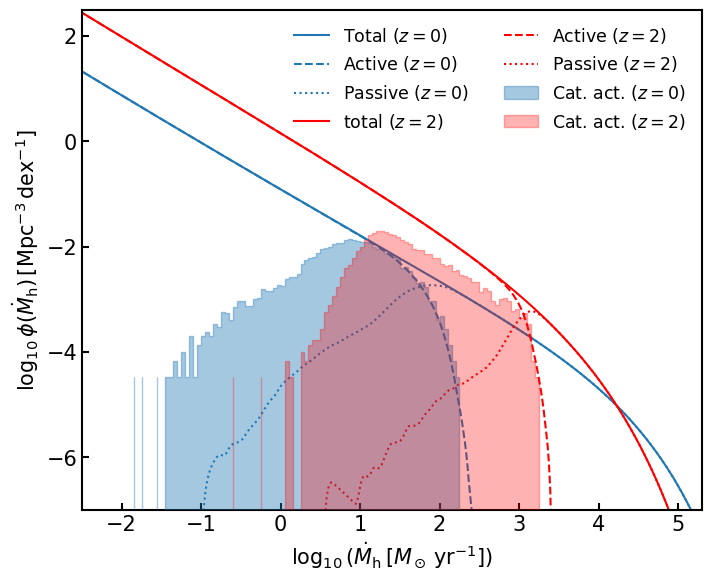

In [16]:
#plt.figure(figsize=(6,4.5))
plt.figure(figsize=(8,6.5))
#plt.vlines(cut_mhdotlog[0], -7,1, color='b', lw=0.5)
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot[0,:]),color='C0',label="Total ($z=0$)")
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot_active[0,:]),color='C0',linestyle='--',label="Active ($z=0$)")
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot_passive[0,:]),color='C0',linestyle=':',label="Passive ($z=0$)")

#plt.plot(mhdotlog-9.,np.log10(new_dNdVdlogmhdot_active[nearest(z,2),:]),color='black', ls=":",lw=3, label="Active updated")

Z2=2.
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot[nearest(z,Z2),:]),color='red',label="total ($z=2$)")
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot_active[nearest(z,Z2),:]),color='red',linestyle='--',label="Active ($z=2$)")
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot_passive[nearest(z,Z2),:]),color='red',linestyle=':',label="Passive ($z=2$)")

b = 0.05; har_range = np.arange(-6, 6, b)
phi_mhdotlog = np.histogram(dmhdtlog_arr[mhlog_arr[:,nearest(z,0)]<mhlog_crit(0),nearest(z,0)], bins=har_range)[0] / b / volume
#plt.plot(har_range[:-1]+b/2., np.log10(phi_mhdotlog))
plt.fill_between(har_range[:-1]+b, np.repeat(-10, phi_mhdotlog.size), np.log10(phi_mhdotlog), color="C0", step="pre", alpha=0.4, zorder=3, label="Cat. act. ($z=0$)")
print( trapz(phi_mhdotlog, har_range[:-1]) )

phi_mhdotlog = np.histogram(dmhdtlog_arr[mhlog_arr[:,nearest(z,2)]<mhlog_crit(2),nearest(z,2)], bins=har_range)[0] / b / volume
plt.fill_between(har_range[:-1]+b, np.repeat(-10, phi_mhdotlog.size), np.log10(phi_mhdotlog), color="red", step="pre", alpha=0.3, zorder=5, label="Cat. act. ($z=2$)")

plt.xlim(-2.5,5.3)
plt.ylim(-7,2.5)
plt.legend(frameon=False, ncol=2, fontsize=12.5)
plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm h} \, [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
plt.ylabel(r"$\log_{10} \, \phi (\dot{M}_{\rm h}) \, [{\rm Mpc}^{-3} \, {\rm dex}^{-1}]$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("../Figures_thesis/HAR_function_cat.pdf", bbox_inches="tight", dpi=300)


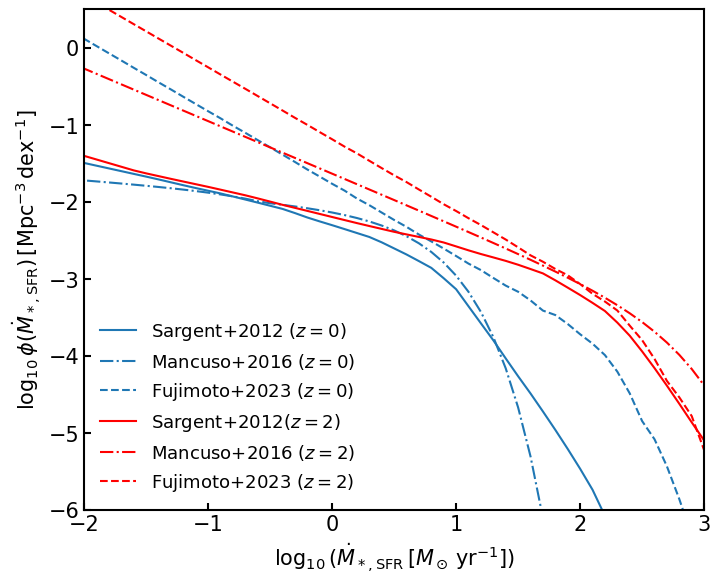

In [79]:
plt.figure(figsize=(8,6.5))

Z1=0.
plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,Z1)]), color="C0", label="Sargent+2012 ($z=0$)")
#plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,1)]), label="$z=1$")
#plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,2)]), color="red", label="Sargent+2012($z=2$)")
#plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,3)]), label="$z=3$")
#plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,4)]), label="$z=4$")

#for Z in [0,1,2.3]:
#    plt.plot(sfrlog, np.log10(phisfrLF_fujimoto[:,nearest(z,Z)]), "--", color="C"+str(Z))
#    plt.plot(sfrlog, np.log10(phisfr_lapi[:,nearest(z,Z)]), "-.", color="C"+str(Z))

phisfrLF_Fujimoto=np.loadtxt("Data/Fujimoto_SFRF/phiSFR_Fujimoto_2023.txt")
plt.plot(sfrlog, np.log10(phisfr_lapi[:,nearest(z,Z1)]), "-.", color="C0", label="Mancuso+2016 ($z=0$)")
plt.plot(sfrlog, np.log10(phisfrLF_Fujimoto[:,nearest(z,Z1)]), "--", color="C0", label="Fujimoto+2023 ($z=0$)")
plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,2)]), color="red", label="Sargent+2012($z=2$)")
plt.plot(sfrlog, np.log10(phisfr_lapi[:,nearest(z,2)]), "-.", color="red", label="Mancuso+2016 ($z=2$)")
plt.plot(sfrlog, np.log10(phisfrLF_Fujimoto[:,nearest(z,2)]), "--", color="red", label="Fujimoto+2023 ($z=2$)")

#bothwell=np.loadtxt("Bothwell_2011/SFRF.txt")
#plt.errorbar(bothwell[:,0], bothwell[:,1], yerr=[ bothwell[:,1]-bothwell[:,2], bothwell[:,3]-bothwell[:,1] ], ls="none", marker="o", capsize=0, color="purple", label="Bothwell+2011")

#plt.plot(10,10, "-", color="black", label="Sargent+2012")
#plt.plot(10,10, "--", color="black", label="Fujimoto+2023")
#plt.plot(10,10, "-.", color="black", label="Mancuso&Lapi")

plt.xlim(-2,3)
plt.ylim(-6,0.5)
plt.legend(frameon=False, fontsize=13, loc="lower left")
plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm *,SFR} \, [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
plt.ylabel(r"$\log_{10} \, \phi (\dot{M}_{\rm *,SFR}) \, [{\rm Mpc}^{-3} \, {\rm dex}^{-1}]$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("../Figures_thesis/SFR_function_comparison.pdf", bbox_inches="tight", dpi=300)

In [ ]:
sfrlog_am_Sargent = abundance_matching(z,nz,mhdotlog,nmhdot, phisfrLF_Sargent, sfrlog,nsfr, dNdVdlogmhdot_active, sigma_sfr)
sfrlog_am_Fujimoto = abundance_matching(z,nz,mhdotlog,nmhdot, phisfrLF_Fujimoto, sfrlog,nsfr, dNdVdlogmhdot_active, sigma_sfr)
sfrlog_am_Lapi = abundance_matching(z,nz,mhdotlog,nmhdot, phisfr_lapi, sfrlog,nsfr, dNdVdlogmhdot_active, sigma_sfr)

for Z in [0,2]:
    plt.plot(mhdotlog-9, sfrlog_am_Sargent[:,nearest(z,Z)], "-", color="C"+str(Z))
    #plt.plot(mhdotlog-9, sfrlog_am_Fujimoto[:,nearest(z,Z)], "--", color="C"+str(Z))
    plt.plot(mhdotlog-9, sfrlog_am_Lapi[:,nearest(z,Z)], "-.", color="C"+str(Z))
plt.plot(10,10, "-", color="black", label="Sargent+2012")
plt.plot(10,10, "--", color="black", label="Fujimoto+2023")
plt.plot(10,10, "-.", color="black", label="Mancuso&Lapi")
plt.legend(frameon=False,fontsize=12)
plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm h})$",fontsize=15)
plt.ylabel(r"$\log_{10} \, (\dot{M}_{\rm *,SFR})$",fontsize=15)
plt.xlim(-1.18,4.5)
plt.ylim(-3,3)

In [ ]:
Z=0
plt.plot(logmstar_integrated[:,nearest(z,Z)], logsigma_arr[:,nearest(z,Z)], ",")
plt.xlim(8.5,12)
plt.ylim(1.6,2.7)

In [ ]:
if blackhole_quenching and bhar_function=="Shen+2020":
    for i,Z in enumerate([0,2]):
        plt.plot(mbhdotlog, np.log10(phimbhdot_nocorr[:,nearest(z,Z)]), "-", color="C"+str(i))
        #plt.plot(mbhdotlog, np.log10(phimbhdot[:,nearest(z,Z)]), "-.", color="C"+str(i))
    plt.xlabel(r"$\log_{10} \, ( \dot{M}_{\rm BH} \, [M_\odot \, {\rm yr}^{-1}])$", fontsize=15)
    plt.ylabel(r"$\log_{10} \, \phi( \dot{M}_{\rm BH} ) [{\rm Mpc}^{-3} \, {\rm dex}^{-1}]$", fontsize=15)
    plt.tick_params(which='major', length=5, width=1.5, direction='in')
    plt.xlim(-5.5,1.2)
    plt.ylim(-5.2, 0.2)
    #plt.savefig("../Figures_paper/MBHdot_function_Shen2020.jpg", bbox_inches="tight", dpi=300)

In [22]:
# PLOT MERGER RATES
if include_mergers and merger_tree=="DECODE":
    #plt.plot(mslog, logMR[:,nearest(z,0)], ",", alpha=0.6)
    plt.plot(logmstar_integrated[:,nearest(z,0)], logMR_cat[:,nearest(z,0)], ",", alpha=0.6)
    plt.plot(logmstar_integrated[:,nearest(z,2)], logMR_cat[:,nearest(z,2)], ",", zorder=-10)
    plt.text(8.8, 2, r"$z=0$", color="C0", fontsize=15)
    plt.text(8.8, 1.5, r"$z=2$", color="C1", fontsize=15)
    plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm *,SFR} [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
    plt.ylabel(r"$\log_{10} \, (\dot{M}_{\rm mergers} [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
    plt.tick_params(which='major', length=5, width=1.5, direction='in')
    plt.xlim(8.5,12)
    plt.ylim(-2.5,2.5)
    #plt.savefig("../Figures_paper/MergerRates.jpg", bbox_inches="tight", dpi=300)

In [47]:
if blackhole_quenching:
    for iz in range(nz):
        #phisfr[:,iz] = np.histogram(sfrlog_cat[:,iz], bins=np.arange(sfrlog[0]-0.05, sfrlog[-1]+0.1, 0.1))[0] / 0.1 / volume
        phisfr_true[:,iz] = np.histogram( np.concatenate((sfrlog_cat[:,iz], sats_sfrlog_cat[iz], delta_sfrlog_cat[iz] )), bins=np.arange(sfrlog[0]-0.05, sfrlog[-1]+0.1, 0.1))[0] / 0.1 / volume
        phimbhdot_cat[:,iz] = np.histogram(mbhdotlog_cat[:,iz], bins=np.arange(mbhdotlog[0]-0.05, mbhdotlog[-1]+0.1, 0.1))[0] / 0.1 / volume
phisfr=np.zeros((nsfr,nz))
phisfr[:,iz] = np.histogram(sfrlog_cat[:,iz], bins=np.arange(sfrlog[0]-0.05, sfrlog[-1]+0.1, 0.1))[0] / 0.1 / volume

NameError: name 'sats_sfrlog_cat' is not defined

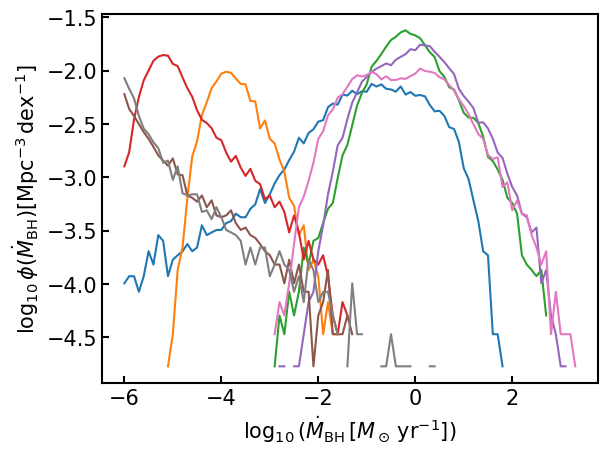

In [21]:
if blackhole_quenching:
    #Z=0
    for Z in [0,1,2,3]:
        plt.plot(sfrlog, np.log10(phisfr_true[:,nearest(z,Z)]))
        plt.plot(mbhdotlog, np.log10(phimbhdot_cat[:,nearest(z,Z)]))
    plt.xlabel(r"$\log_{10} \, ( \dot{M}_{\rm BH} \, [M_\odot \, {\rm yr}^{-1}])$", fontsize=15)
    plt.ylabel(r"$\log_{10} \, \phi( \dot{M}_{\rm BH} ) [{\rm Mpc}^{-3} \, {\rm dex}^{-1}]$", fontsize=15)
    plt.tick_params(which='major', length=5, width=1.5, direction='in')
    #plt.xlim(-5.5,1.2)
    #plt.ylim(-5.2, 0.2)

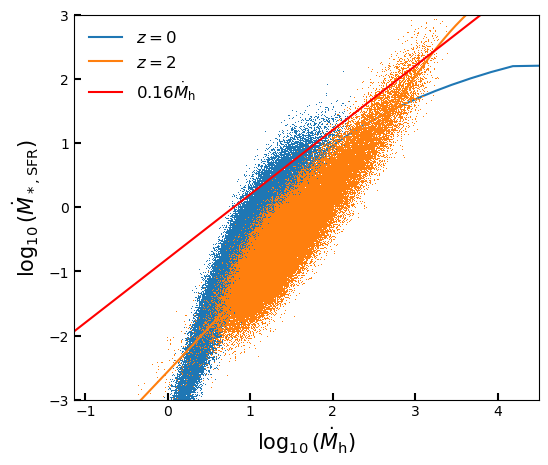

In [25]:
plt.figure(figsize=(6,5))

Z=0
plt.plot(dmhdtlog_arr[:,nearest(z,Z)], sfrlog_cat[:,nearest(z,Z)], ",")
plt.plot(mhdotlog-9,sfrlog_am[:,nearest(z,Z)], color="C0", label=r"$z=0$")
Z=2
plt.plot(dmhdtlog_arr[:,nearest(z,Z)], sfrlog_cat[:,nearest(z,Z)], ",")
plt.plot(mhdotlog-9,sfrlog_am[:,nearest(z,Z)], color="C1", label=r"$z=2$")
plt.plot(mhdotlog-9, mhdotlog-9+np.log10(0.16), color="red", label=r"$0.16 \dot{M}_{\rm h}$")

#plt.plot(mhdotlog-9,sfrlog_am[:,nearest(z,Z)]+2*sigma_sfr, "--", color="C0")
plt.xlim(-1.14,4.5)
plt.ylim(-3,3)
plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm h})$",fontsize=15)
plt.ylabel(r"$\log_{10} \, (\dot{M}_{\rm *,SFR})$",fontsize=15)
#plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')
#plt.title("Sargent+2012", fontsize=15)

#plt.savefig("../Figures_thesis/SFR_HAR_quenchHaloOnly_Sargent+2012.jpg", bbox_inches="tight", dpi=300)

In [40]:
#if blackhole_quenching:
if False:
    carr=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Carraro_2020/BHAR_Mstar_StarForming_0.10<z<0.65.txt")
    plt.errorbar(carr[:,0], carr[:,1], xerr=[carr[:,0]-carr[:,2],carr[:,3]-carr[:,0]], yerr=[carr[:,1]-carr[:,4],carr[:,5]-carr[:,1]], color="red", fmt='d', markersize=10, capsize=1.5, label="C20 ($0.10<z<0.65$)")
    carr=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Carraro_2020/BHAR_Mstar_StarForming_0.65<z<1.30.txt")
    plt.errorbar(carr[:,0], carr[:,1], xerr=[carr[:,0]-carr[:,2],carr[:,3]-carr[:,0]], yerr=[carr[:,1]-carr[:,4],carr[:,5]-carr[:,1]], color="C1", fmt='s', markersize=10, capsize=1.5, label="C20 ($0.65<z<1.30$)")
    carr=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Carraro_2020/BHAR_Mstar_StarForming_1.30<z<2.25.txt")
    plt.errorbar(carr[:,0], carr[:,1], xerr=[carr[:,0]-carr[:,2],carr[:,3]-carr[:,0]], yerr=[carr[:,1]-carr[:,4],carr[:,5]-carr[:,1]], color="turquoise", fmt='o', markersize=10, capsize=1.5, label="C20 ($1.30<z<2.25$)")
    carr=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Carraro_2020/BHAR_Mstar_StarForming_2.25<z<3.50.txt")
    plt.errorbar(carr[:,0], carr[:,1], xerr=[carr[:,0]-carr[:,2],carr[:,3]-carr[:,0]], yerr=[carr[:,1]-carr[:,4],carr[:,5]-carr[:,1]], color="navy", fmt='^', markersize=10, capsize=1.5, label="C20 ($2.25<z<3.50$)")

    colors=["red","C1","turquoise","navy"]
    red_sample=np.array([0.5,1.,2.,3.])
    m=[1.02,0.87,1.18,1.]; q=[-13.7,-11.5,-14.4,-12.2]
    for iz in range(red_sample.size):
        yang=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Yang+2018/BHAR_Mstar_StarForming_z=%.1f.txt"%red_sample[iz])
        plt.plot(yang[:,0], yang[:,1], color=colors[iz], lw=2, label="Y18 ($z=$%.1f)"%red_sample[iz])
        plt.plot(mslog, m[iz]*mslog+q[iz], ":", color=colors[iz], lw=0.5)

    plt.legend(frameon=False, fontsize=12, ncol=2)
    plt.xlim(9.5,11.5)
    plt.ylim(-5.9,-0.5)
    plt.xlabel(r"$\log_{10} \, (M_* / M_\odot )$",fontsize=15)
    plt.ylabel(r"$\log_{10} \, (\dot{M}_{\rm BH} [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
    plt.tick_params(which='major', length=5, width=1.5, direction='in')
    
    #plt.savefig("../Figures_paper/Mbhdot_Mstar_relation_Yang_Carraro.pdf", bbox_inches="tight", dpi=300)

In [21]:
logLx=np.arange(38,50.01,0.1)
nLx = logLx.size
Lxf = Xray_L_function(nz,z,nLx,logLx, work="shen+2020")
eps=0.1
phimbhdot = compute_mbh_accrate_function(nz, z, nLx, logLx, Lxf, nmbhdot, mbhdotlog, eps, 150**3, 39., False, logmstar_integrated, sfrlog_cat, volume)
#mbhdotlog_shen = abundance_matching(z,nz,sfrlog,nsfr, phimbhdot, mbhdotlog, nmbhdot, np.transpose(phisfr_true), sigma_am=sigma_mbhdot)
mbhdot_shen, mbhdotlog_shen = abundance_matching(z,nz,sfrlog,nsfr, phimbhdot, mbhdotlog, nmbhdot, np.transpose(phisfrLF), sigma_am=sigma_mbhdot)


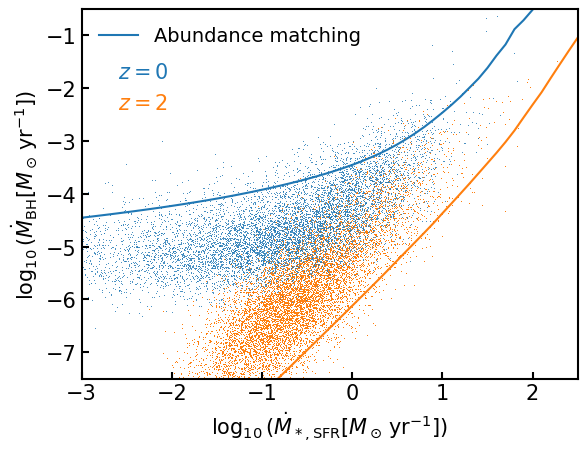

In [22]:
if blackhole_quenching:
    #plt.plot(sfrlog, mbhdotlog_am[:,nearest(z,0)], label=r"$z=0$")
    #plt.plot(sfrlog, mbhdotlog_am[:,nearest(z,1)], label=r"$z=1$")
    #plt.plot(sfrlog, mbhdotlog_am[:,nearest(z,2)], label=r"$z=2$")
    #plt.plot(sfrlog, mbhdotlog_am[:,nearest(z,3)], label=r"$z=3$")
    
    mask=np.logical_and( sfrlog_cat[:,nearest(z,0)]>-66, mbhdotlog_cat[:,nearest(z,0)]>-66 )
    plt.plot(sfrlog_cat[mask,nearest(z,0)], mbhdotlog_cat[mask,nearest(z,0)], ",", color="C0", alpha=0.8)
    plt.plot(sfrlog_cat[mask,nearest(z,2)], mbhdotlog_cat[mask,nearest(z,2)], ",", color="C1", alpha=1, zorder=-10)
    
    plt.plot(sfrlog, mbhdotlog_shen[:,nearest(z,0)], color="C0", label="Abundance matching")
    plt.plot(sfrlog, mbhdotlog_shen[:,nearest(z,2)], color="C1")
    
    plt.text(-2.6, -1.8, r"$z=0$", color="C0", fontsize=15)
    plt.text(-2.6, -2.4, r"$z=2$", color="C1", fontsize=15)
    plt.legend(frameon=False, fontsize=14)
    plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm *,SFR} [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
    plt.ylabel(r"$\log_{10} \, (\dot{M}_{\rm BH} [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
    plt.tick_params(which='major', length=5, width=1.5, direction='in')
    plt.xlim(-3,2.5)
    plt.ylim(-7.5,-0.5)
    
    #plt.savefig("../Figures_paper/SFR_Mbhdot_Mancuso2016_Yang2018.jpg", bbox_inches="tight", dpi=100)

Text(0.5, 0, 'z')

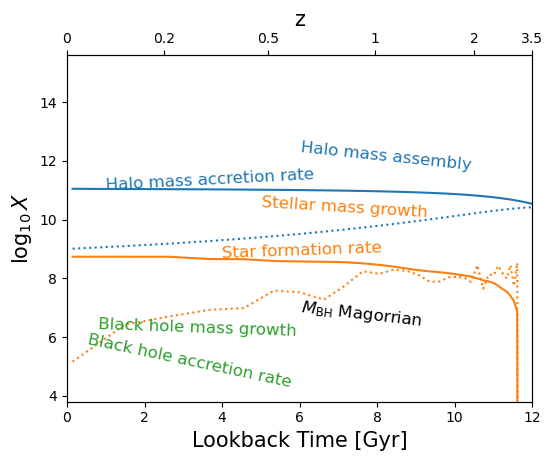

In [26]:
plt.figure(figsize=(6,4.5))
index=9700
plt.plot(lb_time, mhlog_arr[index,:], color="C0", label=r"$M_{\rm h}(z)$")
plt.plot(lb_time, dmhdtlog_arr[index,:]+9., ":", color="C0", label=r"$\dot{M}_{\rm h}(z)\,[M_\odot / {\rm Gyr}]$")
plt.plot(lb_time, logmstar_integrated[index,:], color="C1", label=r"$M_*(z)$")
plt.plot(lb_time, sfrlog_cat[index,:]+9., ":", color="C1", label=r"$\dot{M}_{\rm *,SFR}(z)\,[M_\odot / {\rm Gyr}]$")

#if include_mergers:
#    plt.plot(lb_time, logMR_cat[index,:]+9., "--", color="C1", label=r"$\dot{M}_{\rm *, merger}(z)\,[M_\odot / {\rm Gyr}]$")
if blackhole_quenching:
    plt.plot(lb_time, logmbh_integrated[index,:], color="C2", label=r"$M_{BH}(z)$")
    plt.plot(lb_time, mbhdotlog_cat[index,:]+9., ":", color="C2", label=r"$\dot{M}_{BH}(z)\,[M_\odot / {\rm Gyr}]$")

    #plt.plot(lb_time, logsigma_arr[index,:], color="red")
    #plt.plot(lb_time, Mbh_sigma_relation(logsigma_arr[index,:]), color="black") #Merritt&Ferrarese+2001
    plt.plot(lb_time, logMbhcrit_arr[index,:], color="black")

plt.text(6, 11.7, "Halo mass assembly", color="C0", fontsize=12, rotation=-6.)
plt.text(1, 11., "Halo mass accretion rate", color="C0", fontsize=12, rotation=3)
plt.text(5, 10.1, "Stellar mass growth", color="C1", fontsize=12, rotation=-3.5)
plt.text(4, 8.7, "Star formation rate", color="C1", fontsize=12, rotation=2)
plt.text(0.8, 6.05, "Black hole mass growth", color="C2", fontsize=12, rotation=-2)
plt.text(0.5, 4.3, "Black hole accretion rate", color="C2", fontsize=12, rotation=-12)
plt.text(6, 6.4, r"$M_{\rm BH}$ Magorrian", color="black", fontsize=12, rotation=-6.5)
#plt.text(2.5, 9.3, "Quenching", fontsize=13)
#plt.arrow(5.2, 9.5, 1.9, 0.45, lw=3, head_width=0.3, head_length=0.3, color="black")

#plt.legend(frameon=False, fontsize=13, loc="lower left", ncol=2)
plt.xlabel(r"$z$",fontsize=15)
plt.ylabel(r"$\log_{10} \, X$",fontsize=15)
plt.xlim(0.,12.)
plt.ylim(3.8, 15.6)
#plt.grid()

axes1 = plt.gca()
axes2 = axes1.twiny()

z_tick = np.array([0., 0.2, 0.5, 1., 2., cosmo.lookbackTime(12., inverse=True)])
t_tick = cosmo.lookbackTime(z_tick)
axes2.set_xticks(t_tick)
axes2.set_xticklabels(["0", "0.2", "0.5", "1", "2", "3.5"])

axes1.set_xlabel("Lookback Time [Gyr]")
axes2.set_xlabel("z", fontsize=15)

#plt.savefig("../Figures_paper/mass_acc_STARFORMING_example_BHQuenchOnly_Mancuso2016_Yang2018.pdf", bbox_inches="tight", dpi=300)


Text(0.5, 0, 'z')

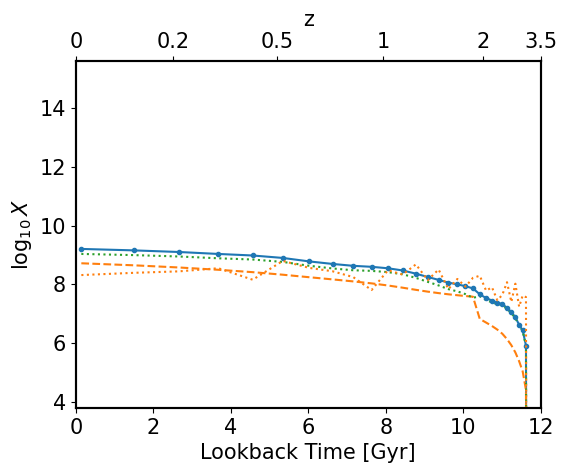

In [40]:
plt.figure(figsize=(6,4.5))
index=2800
plt.plot(lb_time, logmstar_integrated[index,:], label=r"$M_*(z)$")
plt.plot(lb_time, logmbulge[index,:], "--")
plt.plot(lb_time, logmdisc[index,:], ":")
plt.plot(lb_time, np.log10(10**logmdisc[index,:]+10**logmbulge[index,:]), ".", color="C0")
plt.plot(lb_time, sfrlog_cat[index,:]+9., ":", color="C1", label=r"$\dot{M}_{\rm *,SFR}(z)\,[M_\odot / {\rm Gyr}]$")

#plt.legend(frameon=False, fontsize=13, loc="lower left", ncol=2)
plt.xlabel(r"$z$",fontsize=15)
plt.ylabel(r"$\log_{10} \, X$",fontsize=15)
plt.xlim(0.,12.)
plt.ylim(3.8, 15.6)
#plt.grid()

axes1 = plt.gca()
axes2 = axes1.twiny()
z_tick = np.array([0., 0.2, 0.5, 1., 2., cosmo.lookbackTime(12., inverse=True)])
t_tick = cosmo.lookbackTime(z_tick)
axes2.set_xticks(t_tick)
axes2.set_xticklabels(["0", "0.2", "0.5", "1", "2", "3.5"])

axes1.set_xlabel("Lookback Time [Gyr]")
axes2.set_xlabel("z", fontsize=15)

#plt.savefig("../Figures_paper/mass_acc_STARFORMING_example_BHQuenchOnly_Mancuso2016_Yang2018.pdf", bbox_inches="tight", dpi=300)


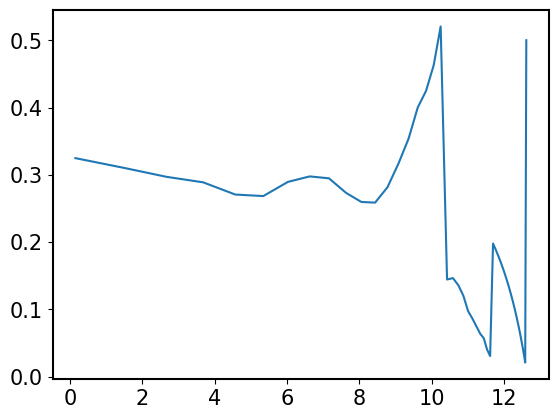

In [41]:
plt.plot(lb_time, BTratio[index,:])

(0.0, 1.0)

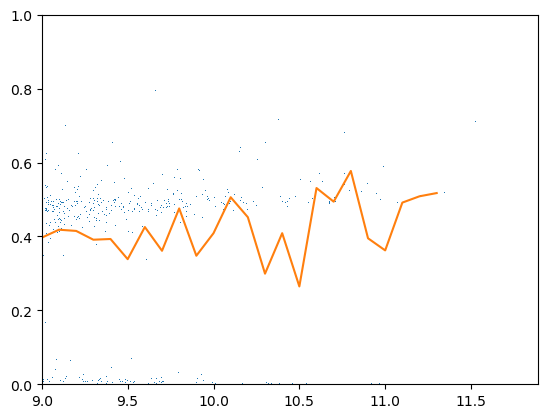

In [71]:
Z=0
index=nearest(z,Z)
plt.plot(logmstar_integrated[:,index],  BTratio[:,index], ",")

mbin=0.1; Mslog=np.arange(8,12.5,mbin)
mean_BTratio = np.array([ np.mean(BTratio[np.logical_and.reduce((BTratio[:,index]>0., logmstar_integrated[:,index]>m-mbin/2., logmstar_integrated[:,index]<=m+mbin/2.)),index]) for m in Mslog ])
plt.plot(Mslog, mean_BTratio)

plt.xlim(9)
plt.ylim(0,1)

(-3.0, 3.771267349800599)

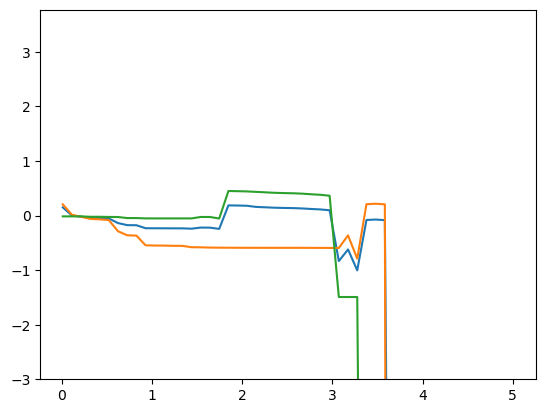

In [26]:
index=9700
plt.plot(z,logRtotal[index,:])
plt.plot(z,logRbulge[index,:])
plt.plot(z,logRdisc[index,:])
plt.ylim(-3)

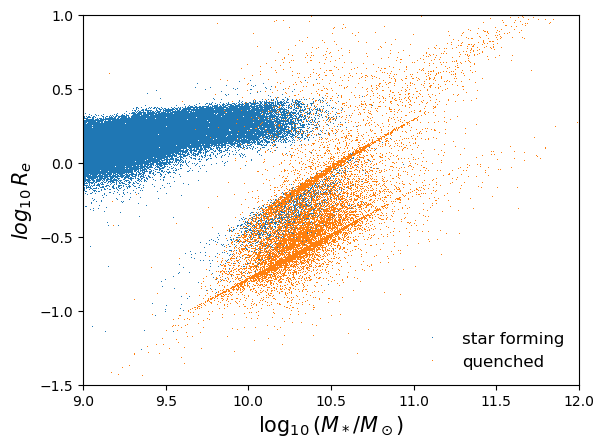

In [30]:
Z=0
index=nearest(z,Z)
sfrlog_threshold=-65.

plt.plot(logmstar_integrated[sfrlog_cat[:,index]>sfrlog_threshold,index],  logRtotal[sfrlog_cat[:,index]>sfrlog_threshold,index], ",", color="C0", label="star forming")
mean_logRtotal = np.array([ np.mean(logRtotal[np.logical_and.reduce((logRtotal[:,index]>-66., logmstar_integrated[:,index]>m-Msbin/2., logmstar_integrated[:,index]<=m+Msbin/2., sfrlog_cat[:,index]>sfrlog_threshold)),index]) for m in Mslog ])
#plt.plot(Mslog, mean_logRtotal, color="C0")

plt.plot(logmstar_integrated[sfrlog_cat[:,index]<=sfrlog_threshold,index],  logRtotal[sfrlog_cat[:,index]<=sfrlog_threshold,index], ",", color="C1", label="quenched")
mean_logRtotal = np.array([ np.mean(logRtotal[np.logical_and.reduce((logRtotal[:,index]>-66., logmstar_integrated[:,index]>m-Msbin/2., logmstar_integrated[:,index]<=m+Msbin/2., sfrlog_cat[:,index]<=sfrlog_threshold)),index]) for m in Mslog ])
#plt.plot(Mslog, mean_logRtotal, color="C1")

#plt.plot(Mslog, 0.05*(Mslog-1.2), color="C0")

plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=15)
plt.ylabel(r"$log_{10}\, R_e$", fontsize=15)
plt.xlim(9,12)
plt.ylim(-1.5,1)
#plt.savefig("../Figures_paper/size_distribution.jpg", bbox_inches="tight", dpi=300)

(-10.5, 3.0)

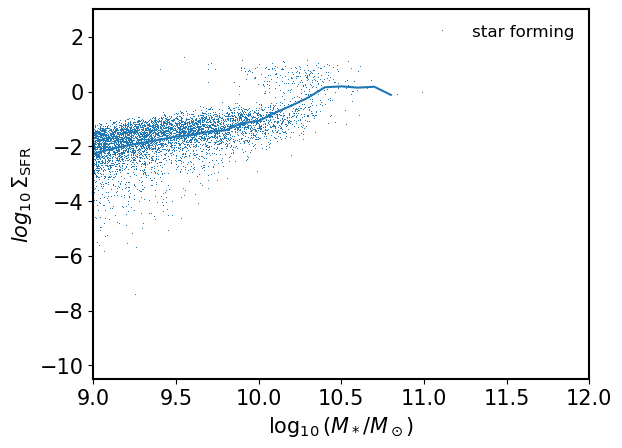

In [30]:
Z=0
index=nearest(z,Z)
sfrlog_threshold=-65.

plt.plot(logmstar_integrated[sfrlog_cat[:,index]>sfrlog_threshold,index],  logSigmaSFR[sfrlog_cat[:,index]>sfrlog_threshold,index], ",", color="C0", label="star forming")
mean_logRtotal = np.array([ np.mean(logSigmaSFR[np.logical_and.reduce((logSigmaSFR[:,index]>-66., logmstar_integrated[:,index]>m-Msbin/2., logmstar_integrated[:,index]<=m+Msbin/2., sfrlog_cat[:,index]>sfrlog_threshold)),index]) for m in Mslog ])
plt.plot(Mslog, mean_logRtotal, color="C0")

#plt.plot(logmstar_integrated[sfrlog_cat[:,index]<=sfrlog_threshold,index],  logSigmaSFR[sfrlog_cat[:,index]<=sfrlog_threshold,index], ",", color="C1", label="quenched")
#mean_logSigmaSFR = np.array([ np.mean(logSigmaSFR[np.logical_and.reduce((logSigmaSFR[:,index]>-66., logmstar_integrated[:,index]>m-Msbin/2., logmstar_integrated[:,index]<=m+Msbin/2., sfrlog_cat[:,index]<=sfrlog_threshold)),index]) for m in Mslog ])
#plt.plot(Mslog, mean_logSigmaSFR, color="C1")

plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=15)
plt.ylabel(r"$log_{10}\, \Sigma_{\rm SFR}$", fontsize=15)
plt.xlim(9,12)
plt.ylim(-10.5,3)

In [ ]:
Z=0
index=nearest(z,Z)
plt.plot(logmstar_integrated[:,index],  BTratio[:,index], ",")

mbin=0.1; Mslog=np.arange(8,12.5,mbin)
mean_BTratio = np.array([ np.mean(BTratio[np.logical_and.reduce((BTratio[:,index]>0., logmstar_integrated[:,index]>m-mbin/2., logmstar_integrated[:,index]<=m+mbin/2.)),index]) for m in Mslog ])
plt.plot(Mslog, mean_BTratio)

plt.xlim(9)
plt.ylim(0,1)

In [21]:
#np.savetxt("Output_data/logsigma_arr.txt", logsigma_arr)
#np.savetxt("Output_data/logmstar_integrated_BHquenchOnly_Mancuso2016_Yang2018.txt", logmstar_integrated)
#np.savetxt("Output_data/sfrlog_cat_BHquenchOnly_Mancuso2016_Yang2018.txt", sfrlog_cat)
#np.savetxt("Output_data/logmbh_integrated_BHquenchOnly_Mancuso2016_Yang2018.txt", logmbh_integrated)
#np.savetxt("Output_data/mbhdotlog_cat_BHquenchOnly_Mancuso2016_Yang2018.txt", mbhdotlog_cat)

No handles with labels found to put in legend.


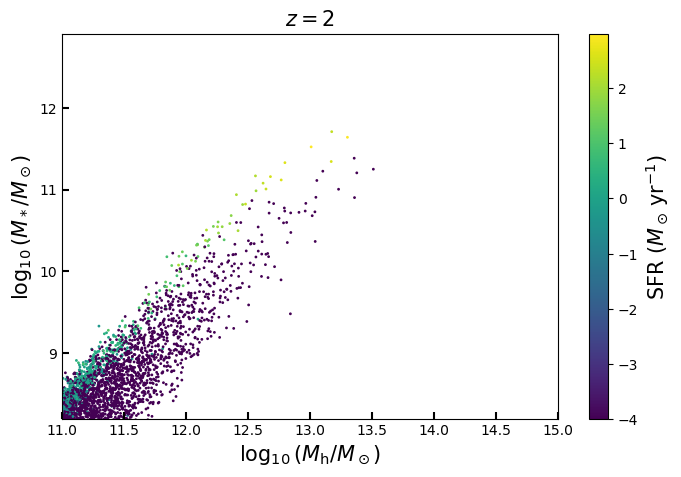

In [84]:
plt.figure(figsize=(8,5))
Z=2
index=nearest(z,Z)
plt.xlim(11.,15.)
plt.ylim(8.2,12.9)
plt.scatter(mhlog_arr[:,index],logmstar_integrated[:,index], s=1,c=sfrlog_cat[:,index],vmin=-4)
mbin=0.1; Mhlog=np.arange(10,15.5,mbin)
mean_smhm = np.array([ np.mean(logmstar_integrated[np.logical_and.reduce((logmstar_integrated[:,index]>0., mhlog_arr[:,index]>m-mbin/2., mhlog_arr[:,index]<=m+mbin/2.)),index]) for m in Mhlog ])
#plt.plot(Mhlog, mean_smhm, color='b', label="Mean")

#plt.plot(Mhlog, Mhlog+np.log10(0.16), color='black')

#popt,pcov=curve_fit(SMHM_double_pl, Mhlog[np.isfinite(mean_smhm)], mean_smhm[np.isfinite(mean_smhm)], p0 = [0.032,12.,2.,0.608])
#plt.plot(Mhlog, SMHM_double_pl(Mhlog,*popt), "-", color="red", label="Double power-law fit")

idx=9900
#for iz in range(nz):
#    plt.plot(mhlog_arr[idx,iz], logmstar_integrated[idx,iz], "o", color="lime")

plt.colorbar().set_label(label=r"SFR ($M_\odot \, {\rm yr}^{-1}$)",size=15)
plt.title("$z=$%.0f"%z[index], fontsize=15)
plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$\log_{10} \, (M_{\rm h} / M_\odot)$",fontsize=15)
plt.ylabel(r"$\log_{10} \, (M_* / M_\odot)$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("../Figures_paper/SMHM_quenchHaloOnly_Mancuso_z=%.2f.jpg"%Z, bbox_inches="tight", dpi=300)

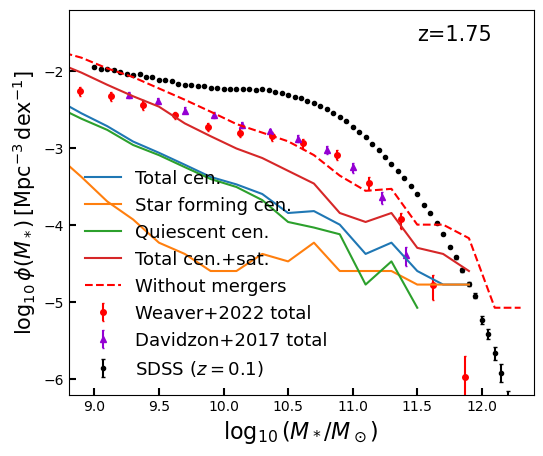

In [86]:
Z = 1.75
b = 0.2; Mstar_range = np.arange(8, 12.5, b)
phi_mslog = np.histogram(logmstar_integrated[:,nearest(z,Z)], bins=Mstar_range)[0] / b / volume
phi_mslog_quench = np.histogram(logmstar_integrated[sfrlog_cat[:,nearest(z,Z)]<-60,nearest(z,Z)], bins=Mstar_range)[0] / b / volume
phi_mslog_active = np.histogram(logmstar_integrated[sfrlog_cat[:,nearest(z,Z)]>-60,nearest(z,Z)], bins=Mstar_range)[0] / b / volume
plt.figure(figsize=(6,5))
plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog), label="Total cen.")
plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog_active), label="Star forming cen.")
plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog_quench), label="Quiescent cen.")

#plt.plot(mslog, np.log10(smf_ac[nearest(z,Z),:]), lw=3, label="input active")

mhlog_smhm=np.arange(10,15.5,b)
mslog_smhm = np.array([ np.mean(logmstar_integrated[np.logical_and.reduce((logmstar_integrated[:,nearest(z,Z)]>8., mhlog_arr[:,nearest(z,Z)]>m-b/2., mhlog_arr[:,nearest(z,Z)]<=m+b/2.)),nearest(z,Z)]) for m in mhlog_smhm ])
scatter_smhm = np.array([ np.std(logmstar_integrated[np.logical_and.reduce((logmstar_integrated[:,nearest(z,Z)]>8., mhlog_arr[:,nearest(z,Z)]>m-b/2., mhlog_arr[:,nearest(z,Z)]<=m+b/2.)),nearest(z,Z)]) for m in mhlog_smhm ])
#smhm = interp1d(mhlog_smhm[np.isfinite(mslog_smhm)], mslog_smhm[np.isfinite(mslog_smhm)], fill_value="extrapolate")
popt,pcov=curve_fit(SMHM_double_pl, mhlog_smhm[np.isfinite(mslog_smhm)], mslog_smhm[np.isfinite(mslog_smhm)], p0 = [0.032,12.,2.,0.608])
smhm = interp1d(Mhlog, SMHM_double_pl(Mhlog,*popt), fill_value="extrapolate")
scatter = np.mean(scatter_smhm[np.isfinite(scatter_smhm)])
#scatter = interp1d(mhlog_smhm[np.isfinite(mslog_smhm)], scatter_smhm[np.isfinite(scatter_smhm)], fill_value="extrapolate")((halo_masses))
#scatter[scatter<0]=0

smhm, scatter = SMHM_scatter_from_logms_cat(logmstar_integrated, mhlog_arr, nearest(z,Z), mhlog_smhm, Mstar_range, b, volume, hmf, mhlog, mhlog_min)

delta_hmf = hmf[:,nearest(z,Z)] - hmf_cat[:,nearest(z,Z)]
halo_masses = compute_objs_from_mass_function(mhlog, delta_hmf, volume, mask=np.logical_and(delta_hmf>0.,mhlog>11))
mslog_mock_cat = smhm(halo_masses) + np.random.normal(0.,scatter, halo_masses.size)
delta_smf = np.histogram(mslog_mock_cat, bins=Mstar_range)[0] / b / volume

correction = compute_subHMF(z[nearest(z,Z)], mhlog, hmf[:,nearest(z,Z)])
halo_masses = compute_objs_from_mass_function(mhlog, correction, volume, mask=mhlog>11)
sats_mslog_mock_cat = smhm(halo_masses) + np.random.normal(0.,scatter, halo_masses.size)
phi_sats = np.histogram(sats_mslog_mock_cat, bins=Mstar_range)[0] / b / volume

phi_mslog_tot=phi_mslog+delta_smf+phi_sats
plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog_tot), label="Total cen.+sat.")

#plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog+delta_smf), "--", color="C0", label="Total cen. true")
    

if include_mergers:
    phi_mslog_NoMerg = np.histogram(logmstar_integrated_NoMerg[:,nearest(z,Z)], bins=Mstar_range)[0] / b / volume
    mslog_smhm = np.array([ np.mean(logmstar_integrated_NoMerg[np.logical_and.reduce((logmstar_integrated_NoMerg[:,nearest(z,Z)]>8., mhlog_arr[:,nearest(z,Z)]>m-b/2., mhlog_arr[:,nearest(z,Z)]<=m+b/2.)),nearest(z,Z)]) for m in mhlog_smhm ])
    smhm, scatter = SMHM_scatter_from_logms_cat(logmstar_integrated_NoMerg, mhlog_arr, nearest(z,Z), mhlog_smhm, Mstar_range, b, volume, hmf, mhlog, mhlog_min)
    delta_hmf = hmf[:,nearest(z,Z)] - hmf_cat[:,nearest(z,Z)]
    halo_masses = compute_objs_from_mass_function(mhlog, delta_hmf, volume, mask=np.logical_and(delta_hmf>0.,mhlog>11))
    mslog_mock_cat_NoMerg = smhm(halo_masses) + np.random.normal(0.,scatter, halo_masses.size)
    delta_smf_NoMerg = np.histogram(mslog_mock_cat, bins=Mstar_range)[0] / b / volume
    correction = compute_subHMF(z[nearest(z,Z)], mhlog, hmf[:,nearest(z,Z)])
    halo_masses = compute_objs_from_mass_function(mhlog, correction, volume, mask=mhlog>11)
    sats_mslog_mock_cat_NoMerg = smhm(halo_masses) + np.random.normal(0.,scatter, halo_masses.size)
    phi_sats_NoMerg = np.histogram(sats_mslog_mock_cat_NoMerg, bins=Mstar_range)[0] / b / volume
    phi_mslog_tot_NoMerg=phi_mslog_NoMerg+delta_smf_NoMerg+phi_sats_NoMerg
    plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog_tot_NoMerg), "--", color="red", label="Without mergers", zorder=-5)

smf_obs = np.loadtxt("Data/Weaver_smf_data/SMF_tot_%.2f.txt"%Z)
plt.errorbar(smf_obs[:,0], smf_obs[:,1], yerr=[ smf_obs[:,1]-smf_obs[:,2], smf_obs[:,3]-smf_obs[:,1] ], ls="none", marker="o", markersize=4, capsize=1, color="red", label="Weaver+2022 total", zorder=-9)

smf_obs = np.loadtxt("Data/Weaver_smf_data/SMF_ac_%.2f.txt"%Z)
#plt.errorbar(smf_obs[:,0], smf_obs[:,1], yerr=[ smf_obs[:,1]-smf_obs[:,2], smf_obs[:,3]-smf_obs[:,1] ], ls="none", marker="o", markersize=4, capsize=1, color="blue", label="Weaver+2022 active")

philog_ac_dav = smf_active(z,nz,ms,nms, work="Davidzon+2017")
philog_pas_dav = smf_passive(z,nz,ms,nms, work="Davidzon+2017")
philog_dav = np.log10(10**philog_ac_dav+10**philog_pas_dav)
#plt.plot(mslog, philog_dav[nearest(z,Z),:], label="Davidzon total")
smf_obs = np.loadtxt("../../Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Davidzon+2017/SMF_Davidzon_tot_%.2f.dat"%Z)
plt.errorbar(smf_obs[:,0], smf_obs[:,1], yerr=[ smf_obs[:,1]-smf_obs[:,2], smf_obs[:,3]-smf_obs[:,1] ], ls="none", marker="^", markersize=4, capsize=1, color="darkviolet", label="Davidzon+2017 total", zorder=-8)

sdss = np.loadtxt("../../Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/SDSS_data/SMF_total.txt")
sdss_sigma = sdss[:,2] / (sdss[:,1] * np.log(10.))
plt.errorbar(sdss[:,0], np.log10(sdss[:,1]), yerr=sdss_sigma, color="black", fmt='.', capsize=1.5, label=r"SDSS ($z=0.1$)", zorder=-10)

#plt.title("Fujimoto+2023", fontsize=15)
plt.text(11.5, -1.6, "z=%.2f"%Z, fontsize=15)
plt.legend(frameon=False, fontsize=13, loc="lower left")
plt.xlim(8.8, 12.4)
plt.ylim(-6.2, -1.2)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=16)
plt.ylabel(r"$\log_{10} \, \phi (M_*) \, [{\rm Mpc}^{-3} \, {\rm dex}^{-1}]$", fontsize=15)
#plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#np.savetxt("Output_data/SMF_quenchHaloOnly_Fujimoto_z=%.2f.txt"%Z, np.transpose([Mstar_range[:-1]+b/2., np.log10(phi_mslog), np.log10(phi_mslog_quench), np.log10(phi_mslog_active), np.log10(phi_mslog_tot), np.log10(phi_mslog_tot_NoMerg)]))
#plt.savefig("../Figures_paper/SMF_BHquenchOnly_Mancuso2016_Yang2018_z=%.2f.pdf"%Z, bbox_inches="tight", dpi=300)


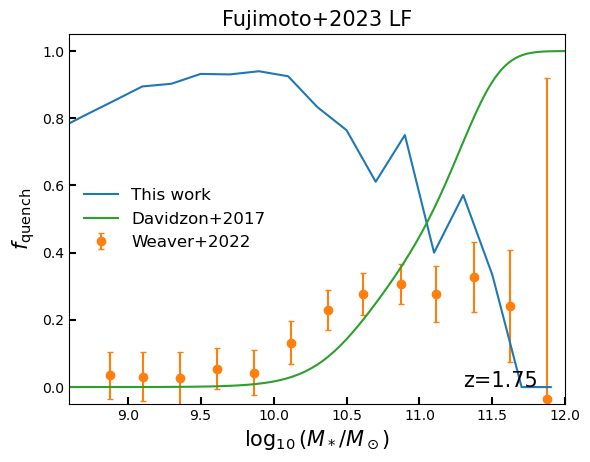

In [87]:
#Z=1.75
f_quenched_sats=0.
f_sats=interp1d(Mstar_range[:-1]+b/2., 1-phi_mslog/phi_mslog_tot,fill_value="extrapolate")(Mstar_range[:-1]+b/2.)
plt.plot(Mstar_range[:-1]+b/2., phi_mslog_quench/phi_mslog, label="This work")#+f_quenched_sats*f_sats)

smf_obs_tot = np.loadtxt("Data/Weaver_smf_data/SMF_tot_%.2f.txt"%Z)
smf_obs_ac = np.loadtxt("Data/Weaver_smf_data/SMF_ac_%.2f.txt"%Z)
smf_tot=interp1d(smf_obs_tot[:,0],smf_obs_tot[:,1],fill_value="extrapolate")
smf_ac=interp1d(smf_obs_ac[:,0],smf_obs_ac[:,1],fill_value="extrapolate")
#plt.plot(Mstar_range, 1-10**smf_ac(Mstar_range)/10**smf_tot(Mstar_range), label="Weaver")
f_obs = np.loadtxt("Data/Weaver_smf_data/frac_quenched_%.2f.txt"%Z)
plt.errorbar(f_obs[:,0], f_obs[:,1], yerr=f_obs[:,2]/2., ls="none", marker="o", capsize=2, label="Weaver+2022")

#f_dav = np.loadtxt("../../Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Davidzon+2017/f_quenched/f_quench_Dav2017.txt")
#plt.plot(f_dav[:,0], f_dav[:,1], "-.", label="Davidzon")
plt.plot(mslog, 10**philog_pas_dav[nearest(z,Z),:]/10**philog_dav[nearest(z,Z),:], label="Davidzon+2017")

plt.text(11.3, 0., "z=%.2f"%Z, fontsize=15)
plt.title("Fujimoto+2023 LF", fontsize=15)
plt.legend(frameon=False,fontsize=12)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=15)
plt.ylabel(r"$f_{\rm quench}$", fontsize=15)
plt.xlim(8.6,12)
plt.ylim(-0.05,1.05)
#plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#np.savetxt("Output_data/f_quench_quenchHaloOnly_Fujimoto_z=%.2f.txt"%Z, np.transpose([Mstar_range[:-1]+b/2., phi_mslog_quench/phi_mslog]))
#plt.savefig("../Figures_paper/f_quench_BHquenchOnly_Mancuso2016_Yang2018_z=%.2f.pdf"%Z, bbox_inches="tight", dpi=300)


(-4.0, 3.0)

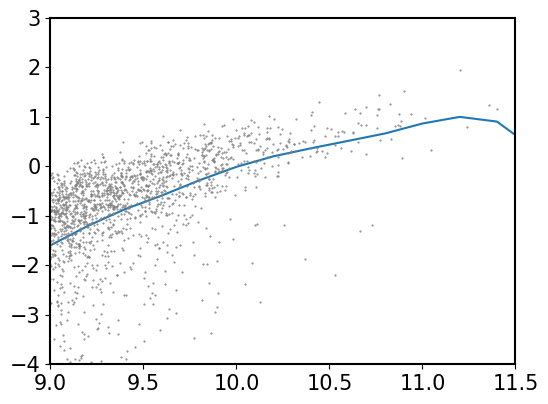

In [26]:
Z=0.
index=nearest(z,Z)
plt.figure(figsize=(6,4.5))
main_sequence = np.array([ np.mean(sfrlog_cat[np.logical_and.reduce((sfrlog_cat[:,index]>-65., logmstar_integrated[:,index]>m-b/2., logmstar_integrated[:,index]<=m+b/2.)),index]) for m in Mstar_range ])

plt.plot(Mstar_range, main_sequence)

mask=np.array([],dtype=bool)
for ihalo in range(nhalo):
    if tree["mratio"][ihalo][np.logical_and(tree["mratio"][ihalo]>=mratio_threshold,tree["z_merge"][ihalo]<3)].size>0:
        mask=np.append(mask,True)
    else:
        mask=np.append(mask,False)

not_mask=np.array([not mask[i] for i in range(mask.size)])
plt.plot(logmstar_integrated[mask,index], sfrlog_cat[mask,index], ".", color="grey", ms=1)
#plt.plot(logmstar_integrated[not_mask,index], sfrlog_cat[not_mask,index], ".", color="orange")

plt.xlim(9,11.5)
plt.ylim(-4,3)

In [19]:
#mratio_threshold=0.25
z_quench=np.zeros(nhalo)-1.
z_previous_majormerger=np.zeros(nhalo)+20.
for ihalo in range(nhalo):
    if z[sfrlog_cat[ihalo,:]<-65.].size>0:
        z_quench[ihalo]=np.max(z[sfrlog_cat[ihalo,:]<-65.])
    if tree["mratio"][ihalo][np.logical_and(tree["mratio"][ihalo]>=mratio_threshold,tree["z_merge"][ihalo]>z_quench[ihalo])].size>0:
        z_previous_majormerger[ihalo]=np.min(tree["z_merge"][ihalo][np.logical_and(tree["mratio"][ihalo]>=mratio_threshold,tree["z_merge"][ihalo]>z_quench[ihalo])])

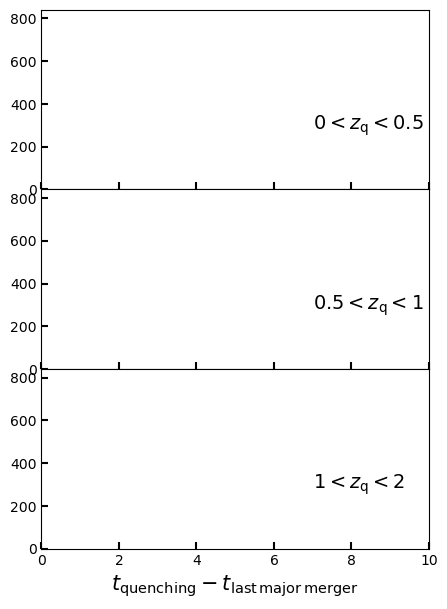

In [20]:
t_bin=0.5
t_range=np.arange(0,12,t_bin)

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, gridspec_kw={'wspace': 0., 'hspace': 0., 'height_ratios': [1,1,1]}, figsize=(5,7))

mass_low=10.; mass_up=10.5
z_low=[0.,0.,1.]; z_up=[3.5,1.,2.]
labels=[r"$0<z_{\rm q}<0.5$", r"$0.5<z_{\rm q}<1$", r"$1<z_{\rm q}<2$"]
for i in range(3):
    mask_mass=np.logical_and(logmstar_integrated[:,0]>mass_low,logmstar_integrated[:,0]<mass_up)
    mask=np.logical_and.reduce((z_quench>z_low[i],z_quench<z_up[i],z_previous_majormerger>0.,z_previous_majormerger<10.))
    mask=np.logical_and(mask,mask_mass)
    deltaT=cosmo.lookbackTime(z_previous_majormerger[mask])-cosmo.lookbackTime(z_quench[mask])
    phi_deltaT=np.histogram(deltaT,bins=t_range)[0]
    ax[i].fill_between(t_range[:-1], np.repeat(0, phi_deltaT.size), phi_deltaT, step="post", alpha=0.8)
    ax[i].text(7,280,labels[i],fontsize=14)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,840)
    ax[i].set_xlabel(r"$t_{\rm quenching} - t_{\rm last \, major \, merger}$", fontsize=15)
    ax[i].tick_params(which='major', length=5, width=1.5, direction='in')


In [21]:
mask=np.logical_and(z_previous_majormerger<20, z_quench>=0)
deltaT=cosmo.lookbackTime(z_previous_majormerger[mask])-cosmo.lookbackTime(z_quench[mask])

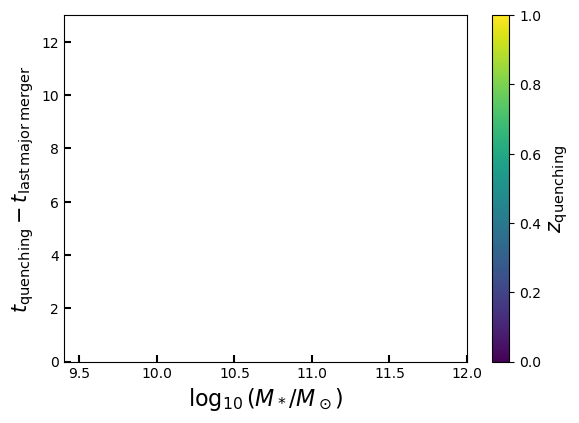

In [22]:
plt.figure(figsize=(6.5,4.5))
plt.scatter(logmstar_integrated[mask,0], deltaT, s=1,c=z_quench[mask],vmin=0)
plt.colorbar().set_label(label=r"$z_{\rm quenching}$",size=15)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=16)
plt.ylabel(r"$t_{\rm quenching} - t_{\rm last \, major \, merger}$", fontsize=15)
plt.xlim(9.4,12)
plt.ylim(0,13)
plt.tick_params(which='major', length=5, width=1.5, direction='in')
#plt.savefig("../Figures_paper/deltaT_quench_colorplot_BHsQuench.jpg", bbox_inches="tight", dpi=300)

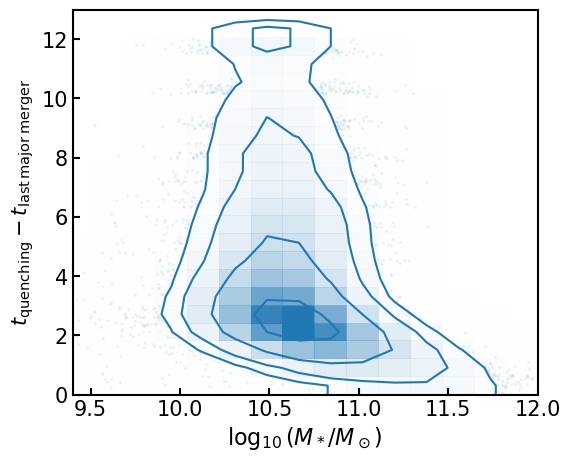

In [52]:
plt.figure(figsize=(6,5))
corner.hist2d(logmstar_integrated[mask,0], deltaT, color="C0", smooth = True, quantiles=[0.68, 0.95, 0.997])
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=16)
plt.ylabel(r"$t_{\rm quenching} - t_{\rm last \, major \, merger}$", fontsize=15)
plt.xlim(9.4,12)
plt.ylim(0,13)
plt.tick_params(which='major', length=5, width=1.5, direction='in')
#plt.savefig("../Figures_paper/deltaT_quench_cornerplot.pdf", bbox_inches="tight", dpi=300)

In [21]:
def straight_line(x,m,q):
    return m*x+q

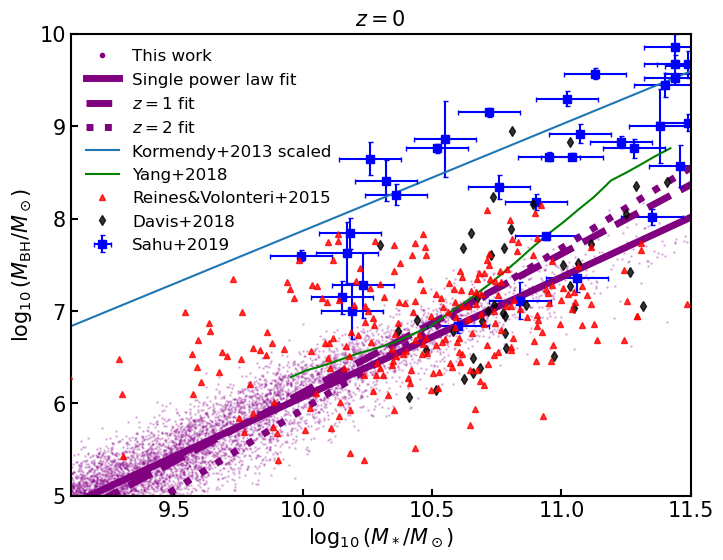

In [22]:
if blackhole_quenching:
    plt.figure(figsize=(8,6))
    Z=0.
    index=nearest(z,Z)
    #plt.scatter(logmstar_integrated[:,index], logmbh_integrated[:,index], s=1,c=sfrlog_cat[:,index],vmin=-4, label="This work")
    plt.plot(0, 0, ".", color="purple", zorder=1, label="This work")
    plt.plot(logmstar_integrated[:,index], logmbh_integrated[:,index], ".", color="darkmagenta", markersize=2, alpha=0.2, zorder=1)
    mbin=0.1; Mslog=np.arange(8,12.5,mbin)
    #mean_mbhms = np.array([ np.mean(logmbh_integrated[np.logical_and.reduce((logmbh_integrated[:,index]>0., logmstar_integrated[:,index]>m-mbin/2., logmstar_integrated[:,index]<=m+mbin/2.)),index]) for m in Mslog ])
    #plt.plot(Mslog, mean_mbhms, color='b', label="Mean")
    
    popt,pcov=curve_fit(straight_line, logmstar_integrated[:,index], logmbh_integrated[:,index])
    plt.plot(Mslog, straight_line(Mslog,*popt), color="purple", lw=5, label="Single power law fit")
    plt.plot(Mslog, straight_line(Mslog,*[1.498, -8.859]), "--", color="purple", lw=5, label="$z=1$ fit")
    plt.plot(Mslog, straight_line(Mslog,*[1.743, -11.493]), ":", color="purple", lw=5, label="$z=2$ fit")

    #plt.plot(Mslog, 1.15*Mslog-4.03, label="Kormendy+2013")
    plt.plot(Mslog, 1.15*Mslog-3.63, label="Kormendy+2013 scaled")

    yang=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Yang+2018/Mbh_Mstar_relation_z=0.txt")
    plt.plot(yang[:,0],yang[:,1],color="green", label=r"Yang+2018")

    reines=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Reines_Volonteri_2015/Mbh_Mstar_relation.txt")
    plt.plot(reines[:,0], reines[:,1], "^", markersize=4.5, color="red", alpha=0.8, label="Reines&Volonteri+2015", zorder=4)

    davis=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Davis_2018/Mbh_Mstar_relation.txt")
    plt.plot(davis[:,0], davis[:,1], "d", markersize=5, color="black", alpha=0.8, label="Davis+2018", zorder=3)
    
    sahu=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Sahu_2019/Mbh_Mstar_Table4.txt")
    plt.errorbar(sahu[:,2], sahu[:,0], xerr=sahu[:,3], yerr=sahu[:,1], color="blue", ls="none", marker="s", capsize=1.8, label="Sahu+2019", zorder=2)

    #plt.colorbar().set_label(label=r"SFR ($M_\odot \, {\rm yr}^{-1}$)",size=15)
    plt.xlim(9.1,11.5)
    plt.ylim(5,10)
    plt.title("$z=$%.0f"%z[index], fontsize=15)
    plt.legend(frameon=False, fontsize=12)
    plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$",fontsize=15)
    plt.ylabel(r"$\log_{10} \, (M_{\rm BH} / M_\odot)$",fontsize=15)
    plt.tick_params(which='major', length=5, width=1.5, direction='in')

    #plt.savefig("../Figures_paper/Mbh_Mstar_relation_z=0.jpg", bbox_inches="tight", dpi=300)

In [39]:
logsigma

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9])

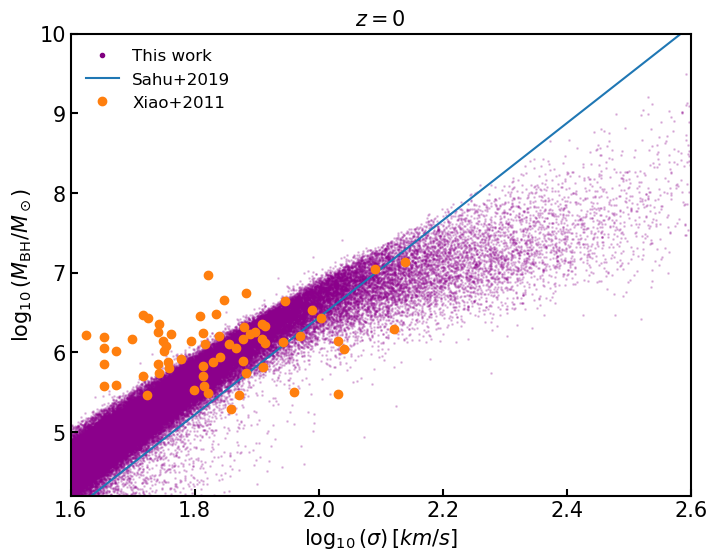

In [59]:
if blackhole_quenching:
    plt.figure(figsize=(8,6))
    Z=0.
    index=nearest(z,Z)
    plt.plot(0, 0, ".", color="purple", zorder=1, label="This work")
    plt.plot(logsigma_arr[:,index], logmbh_integrated[:,index], ".", color="darkmagenta", markersize=2, alpha=0.2, zorder=1)
    sbin=0.1
    mean_mbhsigma = np.array([ np.mean(logmbh_integrated[np.logical_and.reduce((logmbh_integrated[:,index]>0., logsigma_arr[:,index]>s-sbin/2., logsigma_arr[:,index]<=s+sbin/2.)),index]) for s in logsigma ])
    #plt.plot(logsigma, mean_mbhsigma, color='b', label="Mean")
    
    #popt,pcov=curve_fit(straight_line, logsigma_arr[:,index], logmbh_integrated[:,index])
    #plt.plot(logsigma, straight_line(logsigma,*popt), color="purple", lw=5, label="Single power law fit")
    #plt.plot(Mslog, straight_line(Mslog,*[1.498, -8.859]), "--", color="purple", lw=5, label="$z=1$ fit")
    #plt.plot(Mslog, straight_line(Mslog,*[1.743, -11.493]), ":", color="purple", lw=5, label="$z=2$ fit")
    
    plt.plot(logsigma, 6.1*(logsigma-np.log10(200.))+8.27, label="Sahu+2019")
    
    xiao=np.loadtxt("../../Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Xiao+2011/Mbh_sigma.txt")
    plt.plot(xiao[:,0], xiao[:,1], "o", label="Xiao+2011")

    #plt.colorbar().set_label(label=r"SFR ($M_\odot \, {\rm yr}^{-1}$)",size=15)
    plt.xlim(1.6,2.6)
    plt.ylim(4.2,10)
    plt.title("$z=$%.0f"%z[index], fontsize=15)
    plt.legend(frameon=False, fontsize=12)
    plt.xlabel(r"$\log_{10} \, (\sigma) \, [{km/s}]$",fontsize=15)
    plt.ylabel(r"$\log_{10} \, (M_{\rm BH} / M_\odot)$",fontsize=15)
    plt.tick_params(which='major', length=5, width=1.5, direction='in')

    #plt.savefig("../Figures_paper/Mbh_sigma_relation_z=0.jpg", bbox_inches="tight", dpi=300)

In [108]:
print(popt)
print(np.sqrt(np.diag(pcov)))

[  1.74345489 -11.49264334]
[0.00075601 0.00630717]


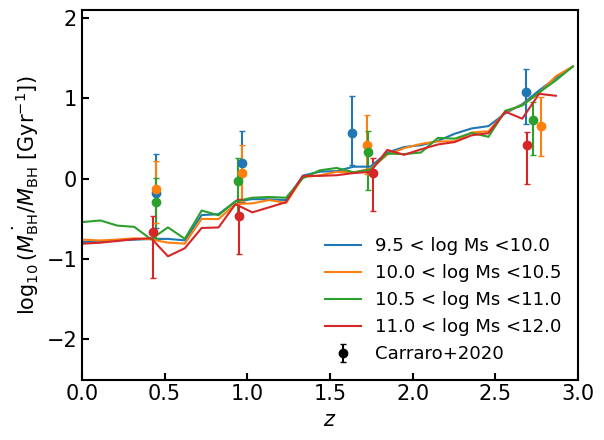

In [61]:
nMassRange=4
MassRange=[[9.5,10.],[10.,10.5],[10.5,11.],[11.,12.]]
sBHAR = [np.zeros(nz) for i in range(nMassRange)]
for iMR in range(nMassRange):
    for iz in range(nz):
        mask = np.logical_and.reduce((logmstar_integrated[:,iz]>MassRange[iMR][0], logmstar_integrated[:,iz]<MassRange[iMR][1], sfrlog_cat[:,iz]>-66.))
        sBHAR[iMR][iz] = np.mean(10.**mbhdotlog_cat[mask,iz]/mbh_integrated[mask,iz])

for iMR in range(nMassRange):
    plt.plot(z, np.log10(sBHAR[iMR]*1e9), color="C"+str(iMR), label=r"{:.1f} < log Ms <{:.1f}".format(MassRange[iMR][0],MassRange[iMR][1]))
    data=np.loadtxt("Carraro_BHs_evo/sBHAR_{:.1f}<logMs<{:.1f}.txt".format(MassRange[iMR][0],MassRange[iMR][1]))
    plt.errorbar(data[:,0], data[:,1], yerr=[data[:,1]-data[:,2], data[:,3]-data[:,1]], ls="none", marker="o", capsize=2, color="C"+str(iMR))
plt.errorbar(-10, -10, yerr=[1], ls="none", marker="o", capsize=2, color="black", label="Carraro+2020")
plt.legend(frameon=False, fontsize=13)
plt.xlim(0,3)
plt.ylim(-2.5,2.1)
plt.xlabel(r"$z$", fontsize=15)
plt.ylabel(r"$\log_{10} \, ( \dot{M_{\rm BH}} / M_{\rm BH} \,\, [{\rm Gyr}^{-1}])$", fontsize=15)
#plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("../Figures_paper/sBHARevo_BHquenchOnly_Mancuso2016_Yang2018.pdf", bbox_inches="tight", dpi=300)

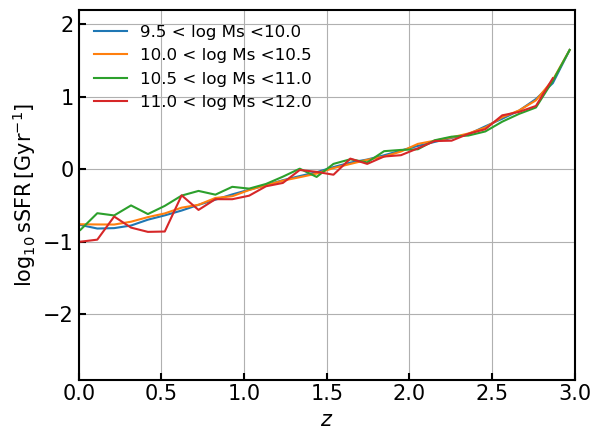

In [62]:
nMassRange=4
MassRange=[[9.5,10.],[10.,10.5],[10.5,11.],[11.,12.]]
sSFR = [np.zeros(nz) for i in range(nMassRange)]
for iMR in range(nMassRange):
    for iz in range(nz):
        mask = np.logical_and.reduce((logmstar_integrated[:,iz]>MassRange[iMR][0], logmstar_integrated[:,iz]<MassRange[iMR][1], sfrlog_cat[:,iz]>-66.))
        sSFR[iMR][iz] = np.mean(10.**sfrlog_cat[mask,iz]/mstar_integrated[mask,iz])

for iMR in range(nMassRange):
    plt.plot(z, np.log10(sSFR[iMR]*1e9), color="C"+str(iMR), label=r"{:.1f} < log Ms <{:.1f}".format(MassRange[iMR][0],MassRange[iMR][1]))
plt.legend(frameon=False, fontsize=12)
plt.xlim(0,3)
plt.ylim(-2.9,2.2)
plt.xlabel(r"$z$", fontsize=15)
plt.ylabel(r"$\log_{10} \, {\rm sSFR} \, [{\rm Gyr}^{-1}]$", fontsize=15)
plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("Figures/sSFR_evolution_Sargent2012.pdf", bbox_inches="tight", dpi=300)

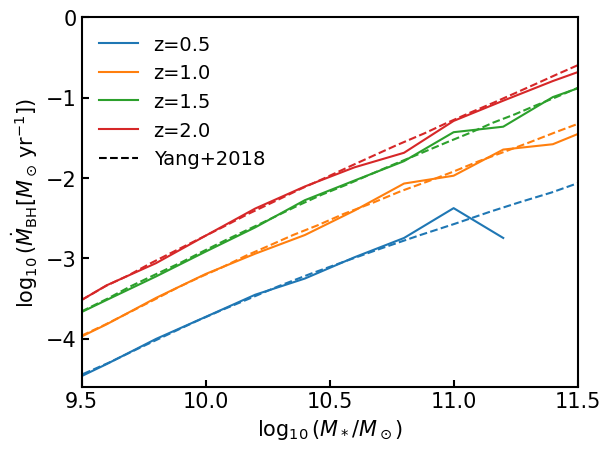

In [63]:
b = 0.2; Mstar_range = np.arange(9, 12., b)
for i,Z in enumerate([0.5, 1., 1.5, 2.]):
    BHAR=np.zeros(Mstar_range.size)
    for im,Ms in enumerate(Mstar_range):
        mask=np.logical_and.reduce((logmstar_integrated[:,nearest(z,Z)]>Ms-b/2., logmstar_integrated[:,nearest(z,Z)]<Ms+b/2., sfrlog_cat[:,nearest(z,Z)]>-66.))
        BHAR[im]=np.mean(mbhdotlog_cat[mask,nearest(z,Z)])
    plt.plot(Mstar_range, BHAR, label="z=%.1f"%Z)
    yang=np.loadtxt("/Users/haofu/GalaxyProjects/Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Yang+2018/BHAR_Mstar_StarForming_z=%.1f.txt"%Z)
    plt.plot(yang[:,0], yang[:,1], "--", color="C"+str(i))
plt.plot(0, 0, "--", color="black", label="Yang+2018")
plt.xlim(9.5,11.5)
plt.ylim(-4.6,0)
plt.legend(frameon=False, fontsize=14)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=15)
plt.ylabel(r"$\log_{10} \, (\dot{M}_{\rm BH} [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("../Figures_paper/BHAR_Mstar_BHquenchOnly_Mancuso2016_Yang2018.pdf", bbox_inches="tight", dpi=300)
